<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">COLLABORATIVE FILTERING</font></h1>

Recommendation systems are a collection of algorithms used to recommend items to users based on information taken from the user. These systems have become ubiquitous can be commonly seen in online stores, movies databases and job finders. In this notebook, we will explore recommendation systems based on Collaborative Filtering and implement simple version of one using Python and the Pandas library.

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#ref1">Acquiring the Data</a></li>
        <li><a href="#ref2">Preprocessing</a></li>
        <li><a href="#ref3">Collaborative Filtering</a></li>
    </ol>
</div>
<br>
<hr>



<a id="ref1"></a>
# Acquiring the Data

To acquire and extract the data, simply run the following Bash scripts:  
Dataset acquired from [GroupLens](http://grouplens.org/datasets/movielens/). Lets download the dataset. To download the data, we will use **`!wget`** to download it from IBM Object Storage.  
__Did you know?__ When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)

In [1]:
!wget -O moviedataset.zip https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/moviedataset.zip
print('unziping ...')
!unzip -o -j moviedataset.zip 

--2020-07-07 18:40:09--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/moviedataset.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160301210 (153M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>] 152.88M  21.6MB/s    in 7.6s    

2020-07-07 18:40:17 (20.1 MB/s) - ‘moviedataset.zip’ saved [160301210/160301210]

unziping ...
Archive:  moviedataset.zip
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: README.txt              
  inflating: tags.csv                


Now you're ready to start working with the data!

<hr>

<a id="ref2"></a>
# Preprocessing

First, let's get all of the imports out of the way:

In [2]:
#Dataframe manipulation library
import pandas as pd
#Math functions, we'll only need the sqrt function so let's import only that
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now let's read each file into their Dataframes:

In [3]:
#Storing the movie information into a pandas dataframe
movies_df = pd.read_csv('movies.csv')
#Storing the user information into a pandas dataframe
ratings_df = pd.read_csv('ratings.csv')

Let's also take a peek at how each of them are organized:

In [4]:
#Head is a function that gets the first N rows of a dataframe. N's default is 5.
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


So each movie has a unique ID, a title with its release year along with it (Which may contain unicode characters) and several different genres in the same field. Let's remove the year from the title column and place it into its own one by using the handy [extract](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.extract.html#pandas.Series.str.extract) function that Pandas has.

Let's remove the year from the __title__ column by using pandas' replace function and store in a new __year__ column.

In [5]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())

Let's look at the result!

In [6]:
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


With that, let's also drop the genres column since we won't need it for this particular recommendation system.

In [7]:
#Dropping the genres column
movies_df = movies_df.drop('genres', 1)

Here's the final movies dataframe:

In [8]:
movies_df.head()

,movieId,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


<br>

Next, let's look at the ratings dataframe.

In [9]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


Every row in the ratings dataframe has a user id associated with at least one movie, a rating and a timestamp showing when they reviewed it. We won't be needing the timestamp column, so let's drop it to save on memory.

In [10]:
#Drop removes a specified row or column from a dataframe
ratings_df = ratings_df.drop('timestamp', 1)

Here's how the final ratings Dataframe looks like:

In [11]:
ratings_df.head()

,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0


<hr>

<a id="ref3"></a>
# Collaborative Filtering

Now, time to start our work on recommendation systems. 

The first technique we're going to take a look at is called __Collaborative Filtering__, which is also known as __User-User Filtering__. As hinted by its alternate name, this technique uses other users to recommend items to the input user. It attempts to find users that have similar preferences and opinions as the input and then recommends items that they have liked to the input. There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the __Pearson Correlation Function__.

<img src="https://ibm.box.com/shared/static/1ql8cbwhtkmbr6nge5e706ikzm5mua5w.png" width=800px>


The process for creating a User Based recommendation system is as follows:
- Select a user with the movies the user has watched
- Based on his rating to movies, find the top X neighbours 
- Get the watched movie record of the user for each neighbour.
- Calculate a similarity score using some formula
- Recommend the items with the highest score


Let's begin by creating an input user to recommend movies to:

Notice: To add more movies, simply increase the amount of elements in the userInput. Feel free to add more in! Just be sure to write it in with capital letters and if a movie starts with a "The", like "The Matrix" then write it in like this: 'Matrix, The' .

In [12]:
userInput = [
            {'title':'Breakfast Club, The', 'rating':5},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title':"Pulp Fiction", 'rating':5},
            {'title':'Akira', 'rating':4.5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Breakfast Club, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


#### Add movieId to input user
With the input complete, let's extract the input movies's ID's from the movies dataframe and add them into it.

We can achieve this by first filtering out the rows that contain the input movies' title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.

In [13]:
#Filtering out the movies by title
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('year', 1)
#Final input dataframe
#If a movie you added in above isn't here, then it might not be in the original 
#dataframe or it might spelled differently, please check capitalisation.
inputMovies

,movieId,title,rating
0,1,Toy Story,3.5
1,2,Jumanji,2.0
2,296,Pulp Fiction,5.0
3,1274,Akira,4.5
4,1968,"Breakfast Club, The",5.0


#### The users who has seen the same movies
Now with the movie ID's in our input, we can now get the subset of users that have watched and reviewed the movies in our input.


In [14]:
#Filtering out users that have watched movies that the input has watched and storing it
userSubset = ratings_df[ratings_df['movieId'].isin(inputMovies['movieId'].tolist())]
userSubset.head()

,userId,movieId,rating
19,4,296,4.0
441,12,1968,3.0
479,13,2,2.0
531,13,1274,5.0
681,14,296,2.0


We now group up the rows by user ID.

In [15]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
userSubsetGroup = userSubset.groupby(['userId'])

lets look at one of the users, e.g. the one with userID=1130

In [16]:
userSubsetGroup.get_group(1130)

,userId,movieId,rating
104167,1130,1,0.5
104168,1130,2,4.0
104214,1130,296,4.0
104363,1130,1274,4.5
104443,1130,1968,4.5


Let's also sort these groups so the users that share the most movies in common with the input have higher priority. This provides a richer recommendation since we won't go through every single user.

In [17]:
#Sorting it so users with movie most in common with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

Now lets look at the first user

In [18]:
userSubsetGroup[0:3]

[(75,
        userId  movieId  rating
  7507      75        1     5.0
  7508      75        2     3.5
  7540      75      296     5.0
  7633      75     1274     4.5
  7673      75     1968     5.0),
 (106,
        userId  movieId  rating
  9083     106        1     2.5
  9084     106        2     3.0
  9115     106      296     3.5
  9198     106     1274     3.0
  9238     106     1968     3.5),
 (686,
         userId  movieId  rating
  61336     686        1     4.0
  61337     686        2     3.0
  61377     686      296     4.0
  61478     686     1274     4.0
  61569     686     1968     5.0)]

#### Similarity of users to input user
Next, we are going to compare all users (not really all !!!) to our specified user and find the one that is most similar.  
we're going to find out how similar each user is to the input through the __Pearson Correlation Coefficient__. It is used to measure the strength of a linear association between two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below. 

Why Pearson Correlation?

Pearson correlation is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. For example, if you have two vectors X and Y,then, pearson(X, Y) == pearson(X, 2 * Y + 3). This is a pretty important property in recommendation systems because for example two users might rate two series of items totally different in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales .

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0 "Pearson Correlation")

The values given by the formula vary from r = -1 to r = 1, where 1 forms a direct correlation between the two entities (it means a perfect positive correlation) and -1 forms a perfect negative correlation. 

In our case, a 1 means that the two users have similar tastes while a -1 means the opposite.

We will select a subset of users to iterate through. This limit is imposed because we don't want to waste too much time going through every single user.

In [19]:
userSubsetGroup = userSubsetGroup[0:100]

Now, we calculate the Pearson Correlation between input user and subset group, and store it in a dictionary, where the key is the user Id and the value is the coefficient


In [20]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorrelationDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='movieId')
    inputMovies = inputMovies.sort_values(by='movieId')
    #Get the N for the formula
    nRatings = len(group)
    #Get the review scores for the movies that they both have in common
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df['rating'].tolist()
    #Let's also put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0


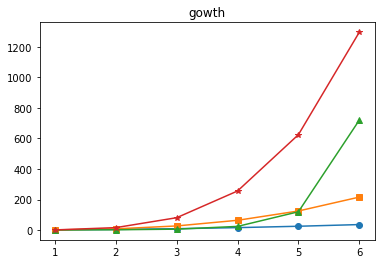

In [56]:
import math
foo_={'a':[1,2,3,4,5,6], 'b':[1,4,9,16,25,36], 'c':[1, 8, 27, 64, 125, 216], 'd':[1, 2, 6, 24, 120, 720]}
foo_df=pd.DataFrame(foo_)
foo_df['e']=foo_df['a']**4


plt.plot(foo_df['a'], foo_df['b'], marker='o')
plt.plot(foo_df['a'], foo_df['c'], marker='s')
plt.plot(foo_df['a'], foo_df['d'], marker='^')
plt.plot(foo_df['a'], foo_df['e'], marker='*')
#plt.plot(foo_df['a'], foo_df['f'], marker='*')
plt.title('gowth')
plt.show()

In [57]:
pearsonCorrelationDict.items()

dict_items([(75, 0.8272781516947562), (106, 0.5860090386731182), (686, 0.8320502943378437), (815, 0.5765566601970551), (1040, 0.9434563530497265), (1130, 0.2891574659831201), (1502, 0.8770580193070299), (1599, 0.4385290096535153), (1625, 0.716114874039432), (1950, 0.179028718509858), (2065, 0.4385290096535153), (2128, 0.5860090386731196), (2432, 0.1386750490563073), (2791, 0.8770580193070299), (2839, 0.8204126541423674), (2948, -0.11720180773462392), (3025, 0.45124262819713973), (3040, 0.89514359254929), (3186, 0.6784622064861935), (3271, 0.26989594817970664), (3429, 0.0), (3734, -0.15041420939904673), (4099, 0.05860090386731196), (4208, 0.29417420270727607), (4282, -0.4385290096535115), (4292, 0.6564386345361464), (4415, -0.11183835382312353), (4586, -0.9024852563942795), (4725, -0.08006407690254357), (4818, 0.4885967564883424), (5104, 0.7674257668936507), (5165, -0.4385290096535153), (5547, 0.17200522903844556), (6082, -0.04728779924109591), (6207, 0.9615384615384616), (6366, 0.65779

In [58]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,0.827278,75
1,0.586009,106
2,0.832050,686
3,0.576557,815
4,0.943456,1040


#### The top x similar users to input user
Now let's get the top 50 users that are most similar to the input.

In [59]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
64,0.961678,12325
34,0.961538,6207
55,0.961538,10707
67,0.960769,13053
4,0.943456,1040


Now, let's start recommending movies to the input user.

#### Rating of selected users to all movies
We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our __pearsonDF__ from the ratings dataframe and then store their correlation in a new column called _similarityIndex". This is achieved below by merging of these two tables.

In [60]:
topUsersRating=topUsers.merge(ratings_df, left_on='userId', right_on='userId', how='inner')
topUsersRating.head()

,similarityIndex,userId,movieId,rating
0,0.961678,12325,1,3.5
1,0.961678,12325,2,1.5
2,0.961678,12325,3,3.0
3,0.961678,12325,5,0.5
4,0.961678,12325,6,2.5


Now all we need to do is simply multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

It shows the idea of all similar users to candidate movies for the input user:

In [61]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,0.961678,12325,1,3.5,3.365874
1,0.961678,12325,2,1.5,1.442517
2,0.961678,12325,3,3.0,2.885035
3,0.961678,12325,5,0.5,0.480839
4,0.961678,12325,6,2.5,2.404196


In [62]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,38.376281,140.800834
2,38.376281,96.656745
3,10.253981,27.254477
4,0.929294,2.787882
5,11.723262,27.151751


In [63]:
#Creates an empty dataframe
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,movieId
movieId,,
1,3.668955,1
2,2.518658,2
3,2.657941,3
4,3.000000,4
5,2.316058,5


Now let's sort it and see the top 20 movies that the algorithm recommended!

In [64]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

,weighted average recommendation score,movieId
movieId,,
5073,5.0,5073
3329,5.0,3329
2284,5.0,2284
26801,5.0,26801
6776,5.0,6776
6672,5.0,6672
3759,5.0,3759
3769,5.0,3769
3775,5.0,3775


In [67]:
movies_df.loc[movies_df['movieId'].isin(recommendation_df.head(10)['movieId'].tolist())]

,movieId,title,year
2200,2284,Bandit Queen,1994
3243,3329,"Year My Voice Broke, The",1987
3669,3759,Fun and Fancy Free,1947
3679,3769,Thunderbolt and Lightfoot,1974
3685,3775,Make Mine Music,1946
4978,5073,"Son's Room, The (Stanza del figlio, La)",2001
6563,6672,War Photographer,2001
6667,6776,Lagaan: Once Upon a Time in India,2001
9064,26801,Dragon Inn (Sun lung moon hak chan),1992
18106,90531,Shame,2011


### Advantages and Disadvantages of Collaborative Filtering

##### Advantages
* Takes other user's ratings into consideration
* Doesn't need to study or extract information from the recommended item
* Adapts to the user's interests which might change over time

##### Disadvantages
* Approximation function can be slow
* There might be a low of amount of users to approximate
* Privacy issues when trying to learn the user's preferences

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>